# NOD risk

From Sharma et al we have:
- NOD 3y risk = 0.9%<br>
- Avg risk = 0.11%

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from csaps import csaps

In [4]:
seer_inc = pd.read_csv("../data/seer_incidence_1y.csv")
seer_inc.iloc[:5]

,Unnamed: 0,Distant Rate,Localized Rate,Regional Rate,Unknown/unstaged Rate,Age,LRD Rate,LRDU Rate,pLocal,pRegional,pDistant,LocalU,RegionalU,DistantU
0,20,0.015638,0.066462,0.003910,0.011729,20,0.086010,0.097739,0.772724,0.045460,0.181816,0.075525,0.004443,0.017771
1,21,0.003894,0.054513,0.007788,0.003894,21,0.066195,0.070089,0.823521,0.117652,0.058826,0.057720,0.008246,0.004123
2,22,0.015596,0.046787,0.000000,0.003899,22,0.062383,0.066282,0.749996,0.000000,0.250004,0.049711,0.000000,0.016571
3,23,0.003888,0.054429,0.019439,0.003888,23,0.077756,0.081644,0.699997,0.250000,0.050003,0.057151,0.020411,0.004082
4,24,0.015566,0.035022,0.011674,0.000000,24,0.062262,0.062262,0.562494,0.187498,0.250008,0.035022,0.011674,0.015566


In [9]:
risk_1y_NOD = 1-(1-0.009)**(1/3)
risk_1y_avg = 1-(1-0.0011)**(1/3)
ratio = risk_1y_NOD / risk_1y_avg
print(f"Literature ratio (0.9% vs 0.11%): {round(ratio,2)}")

Literature ratio (0.9% vs 0.11%): 8.2


Find comparable 3-y incidence group, and identify appropriate weights to increase incidence by, with higher risk ratio in 1st year and decreasing to 3rd year:

In [10]:
avg_risks = seer_inc.query('Age > 71 & Age < 75')['LRDU Rate']
print(f"Incidence ages 72-74: {[round(risk,2) for risk in avg_risks]}")
print(f"Average risk for 72-74 = { round((sum(avg_risks) / 100000) * 100, 3)}%")
risk_ratios = [11.25, 8, 5]
risks_nod = [ratio * risk for ratio, risk in zip(risk_ratios, avg_risks)]
print(f"New incidences: {[round(risk,2) for risk in risks_nod]}")
print(f"New risk: {round((sum(risks_nod)/ 100000) * 100, 3)}%")

Incidence ages 72-74: [35.29, 37.85, 39.72]
Average risk for 72-74 = 0.113%
New incidences: [396.97, 302.81, 198.62]
New risk: 0.898%


Apply above risk ratios to 60, 61, 62 y/o population:

In [11]:
avg_risks =  seer_inc.query('Age > 59 & Age < 63')['LRDU Rate']
risks_nod = [ratio * risk for ratio, risk in zip(risk_ratios, avg_risks)]
print(f"Incidence ages 60-62: {[round(risk,2) for risk in avg_risks]}")
print(f"Average risk for 60-62 = { round((sum(avg_risks) / 100000) * 100, 3)}%")
print(f"New incidences: {[round(risk,2) for risk in risks_nod]}")
print(f"New risk: {round((sum(risks_nod)/ 100000) * 100, 3)}%")

Incidence ages 60-62: [15.67, 16.97, 18.83]
Average risk for 60-62 = 0.051%
New incidences: [176.3, 135.73, 94.15]
New risk: 0.406%


Implement smoothing to not have too irregular increase, while fitting the points:

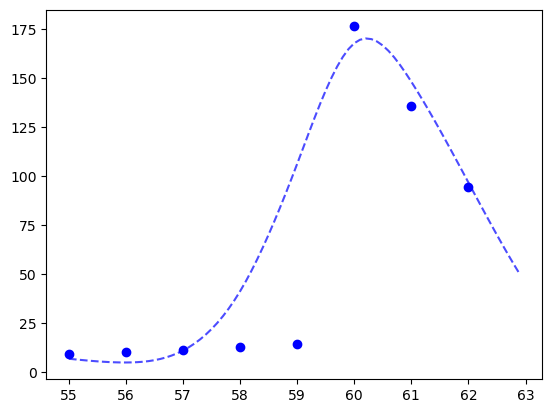

In [13]:
risks_55_62 = np.append(seer_inc.query('Age > 54 & Age < 60')['LRDU Rate'].to_numpy(), risks_nod)
risks_55_62
ages = np.arange(55,63,1)
ages_fin = np.arange(55,63,0.1)
weights = [1, 1, 1, 0.7, 0.5, 12, 3, 3] 
smooth_risks = csaps(ages, risks_55_62, weights=weights, smooth=0.7, axis=0)(ages_fin)
plt.plot(ages_fin, smooth_risks, linestyle='--', alpha=0.7, color='blue', label='Smoothed spline')
plt.scatter(ages, risks_55_62, color='blue', label='Original data')

In [16]:
new_risks_57_62 = csaps(ages, risks_55_62, weights=weights, smooth=0.7, axis=0)(np.arange(57,62,1))
nod_df = seer_inc.query('Age > 56 & Age < 62').copy()
nod_df['LRDU Rate'] = new_risks_57_62
nod_df['LocalU'] = nod_df['pLocal'] * nod_df['LRDU Rate']
nod_df['RegionalU'] = nod_df['pRegional'] * nod_df['LRDU Rate']
nod_df['DistantU'] = nod_df['pDistant'] * nod_df['LRDU Rate']

In [17]:
nod_df.iloc[:5]

,Unnamed: 0,Distant Rate,Localized Rate,Regional Rate,Unknown/unstaged Rate,Age,LRD Rate,LRDU Rate,pLocal,pRegional,pDistant,LocalU,RegionalU,DistantU
37,57,6.630113,0.737185,3.321882,0.268481,57,10.689180,10.866701,0.068966,0.310771,0.620264,0.749428,3.377050,6.740223
38,58,7.783539,0.790991,3.753697,0.341671,58,12.328227,41.149987,0.064161,0.304480,0.631359,2.640223,12.529343,25.980421
39,59,8.484898,1.060004,4.249743,0.379268,59,13.794645,106.205260,0.076842,0.308072,0.615086,8.160993,32.718860,65.325407
40,60,9.761491,1.036619,4.471688,0.401436,60,15.269798,167.756392,0.067887,0.292845,0.639268,11.388459,49.126665,107.241269
41,61,10.218427,1.043339,5.195721,0.508562,61,16.457487,148.071025,0.063396,0.315706,0.620898,9.387112,46.746854,91.937060


In [19]:
nod_df.drop(['Unnamed: 0', 'Distant Rate', 'Localized Rate', 'Regional Rate', 'Unknown/unstaged Rate', 'LRD Rate'], axis=1, inplace=True)

In [20]:
nod_df.to_csv("../data/seer_incidence_nod.csv")